## Estimates of Hawkes process

In [45]:
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize,root_scalar
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import expon, chisquare,chi2,kstest
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy import stats

### Loading the data

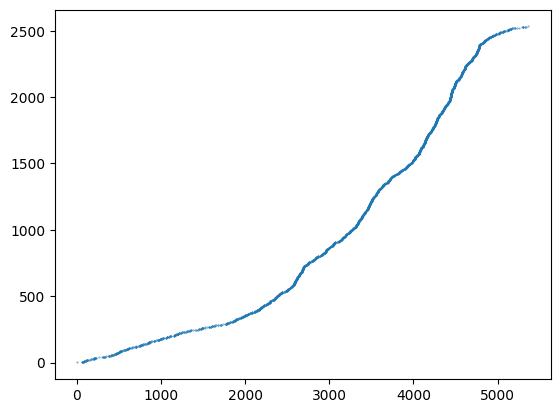

In [46]:
df=pd.read_csv("PRC.csv",sep=';')
dff=df.loc[df['Type of breach']=="HACK",'Date Made Public']
dff=dff.apply(lambda x:datetime.strptime(x,'%m/%d/%Y'))
debut=min(dff)
dff=dff-debut
dff=dff.apply(lambda x:x.days).sort_values()
l=np.asarray(dff)[1:]
unique_l = np.unique(l)
plt.scatter(l,1+np.arange(len(l)),s=0.1)
plt.show()

### initial values for $\alpha$ and  $\beta $

We will define the log-likelihood function as :


$
\log L(N, t) = \sum_{T_n \leq t} \log \left(\alpha + \beta \sum_{j=1}^{n-1} e^{-\gamma\left(T_n-T_j\right)}\right) + (1-\alpha) t - \frac{\beta}{\gamma} \sum_{T_n \leq t} \left(1 - e^{-\gamma\left(t-T_n\right)}\right)
$

Then optimize the parameters using the minimize function from scipy

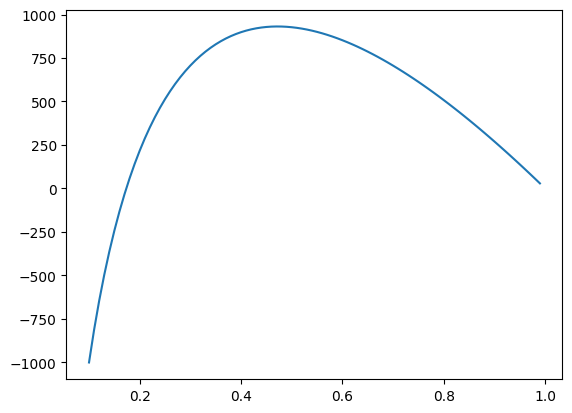

In [47]:
t = l[-1]
alphas= np.arange(0.1, 1, 0.01)
plt.plot(alphas, len(l)*np.log(alphas) + (1-alphas)*t)
plt.show()

Fixing $(\beta, \gamma)$  we get that  the log-likelihood function has a maximum around $\alpha$ close to 0.45 . We will thus choose such an $\alpha$ for initial conditions

We choose $\beta = 0.5$ and $\gamma = 1$ initially because the first log term in the likelihood function pushes $\gamma$ towards zero and $\beta$ to be large, while the second term pushes $\beta$ towards zero and $\gamma$ to be large, so starting in the middle with $\beta = 0.5$ and $\gamma = 1$ is a balanced initial guess.


In [48]:

def log_likelihood(params):
    # Initialize variables
    alpha, beta, gamma = params
    t_max = l[-1]
    log_like = (1-alpha)*t_max

    # Compute the log-likelihood
    for i in range(len(l)):
        sum1 = np.sum(np.exp(-gamma*(l[i]*np.ones(i) - l[:i])))
        log_like += np.log(alpha + beta*sum1)
        log_like -= (beta/gamma) * (1-np.exp(-gamma*(t_max-l[i])))

    return -log_like

In [99]:
# Initial guess for the parameters
initial_params = [0.4728,0.5,1]  # Initial guess for alpha, beta, gamma

# find the optimal parameters

def optimal_parameters():
    # we use the minimization function to find the optimal parameters
    # Review if the constraint beta/gamma >= 1 is appropriate
    constr = [{'type': 'ineq', 'fun': lambda x: x[1]/x[2]-1},
          {'type': 'ineq', 'fun': lambda x: x[0]+1e-8},  # alpha > 0
          {'type': 'ineq', 'fun': lambda x: x[1]+1e-8},  # beta > 0
          {'type': 'ineq', 'fun': lambda x: x[2]+1e-8}]  # gamma > 0
    bnds = ((0,None),(0,None),(0,None))
    res=minimize(log_likelihood,initial_params, method='L-BFGS-B',bounds=bnds,constraints=constr)
    print("Optimization Result:")
    print(res) # Print the optimization result for inspection
    return res.x

# find the optimal parameters for the whole dataset
alpha,beta,gamma=optimal_parameters()


<ipython-input-99-19aec770b403>:14: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  res=minimize(log_likelihood,initial_params, method='L-BFGS-B',bounds=bnds,constraints=constr)
<ipython-input-48-dfd5219c2940>:10: RuntimeWarning: divide by zero encountered in log
  log_like += np.log(alpha + beta*sum1)


Optimization Result:
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -10574.914937255504
        x: [ 3.491e-01  1.179e+04  5.337e+04]
      nit: 28
      jac: [ 8.412e+02  1.455e-02  0.000e+00]
     nfev: 248
     njev: 62
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


**Optimal parameters**

In [100]:
print("alpha optimal = ",alpha)
print("beta optimal = ",beta)
print("gamma optimal = ",gamma)

alpha optimal =  0.34912365336280143
beta optimal =  11793.666515795074
gamma optimal =  53371.22992790704


### Computation of  $\left(y\left(N, T_q(N)\right), n \geq 1\right)$

We will compute y(N,t) using the following formula  in exercise 3.4.2
$$y(N,t)=\alpha t + \frac{\beta}{\gamma} \sum_{T_n\leq t} (1-e^{-\gamma (t-T_n)})$$

In [101]:


#alpha, beta, gamma = optimal_parameters()

# Compute y

y = np.zeros(len(l))
for i in range(len(l)):
    y[i] = alpha*l[i] + beta / gamma * (np.sum(1 - np.exp(-gamma * (l[i] - l[:i]))))

Now that we have computed y, let's compare the distribution of inter-arrival times with generated poisson process .
To do so, we will compare the empirical histogram with the exponential densities

**1)Compare the mean**

In [102]:

inter_intervals = np.diff(y)
mean = np.mean(inter_intervals)
print("Sample mean:", mean)


Sample mean: 0.9597756093462798


We notice the result is close to 1

**Data distribution**

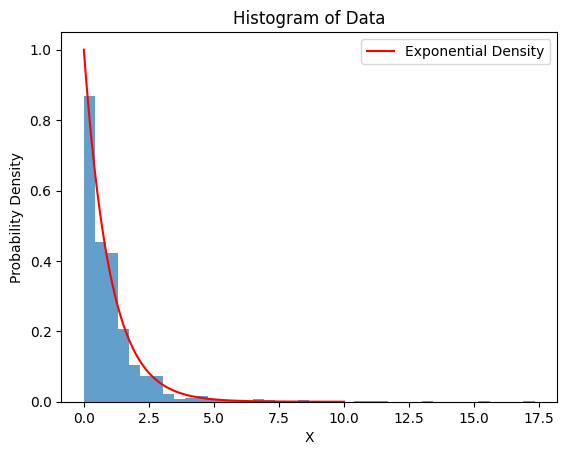

In [103]:
plt.hist(inter_intervals, bins=40, density=True, alpha=0.7)
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.title('Histogram of Data')

# Adding the theorical density plot
x_values = np.linspace(0, 10, 100)
# Exponential density with scale=1
density = stats.expon.pdf(x_values, scale=1)
plt.plot(x_values, density, 'r-', label='Exponential Density')
plt.legend()

plt.show()

The histogram of the data $\left(y\left(N, T_q(N)\right), n \geq 1\right)$ closely matches the exponential density function, indicating that the distribution of the data is close to the law of a Poisson process with intensity 1.


**Kolmogorov-Smirnov test**

In [104]:

# Fit the exponential distribution to the observed gap times
loc, scale = expon.fit(inter_intervals)
# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value =  stats.kstest(inter_intervals, 'expon', args=(loc, scale))
print(f"The Kolmogorov-Smirnov score is {ks_statistic} for a scale of {scale}.")
print(f"The p-value is {p_value}.")

The Kolmogorov-Smirnov score is 0.3765310154089293 for a scale of 0.9597756093462798.
The p-value is 0.0.


**Conclusion :** from the results obtained above, it looks like the generated process of intensity $y(N, t)$ is a Poisson process of intensity 1. This is what we were looking for when conducting the likelihood maximization.